# VU Econometics and Data Science: Case Study
```
Author(s): Jacco Broere
```


### Setup
- Setup config.ini file
- Install necessary packages
- Download and unpack data



In [35]:
# import utility modules
import pandas as pd
import numpy as np
from numpy.linalg import eigh
import configparser
import os
import time

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# helper functions
from helpers.helper_functions import transform_data, add_actuals
from helpers.helper_classes import AddFeatureNames

# sklearn
from sklearn import metrics
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# LightGBM
from lightgbm import LGBMClassifier

# feature_engine
from feature_engine.selection import DropFeatures, DropConstantFeatures, DropDuplicateFeatures

# warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [36]:
# Read config.ini file
config = configparser.ConfigParser()
if os.path.isfile('src/config.ini'):
    config.read('src/config.ini')
elif os.path.isfile('config.ini'):
    config.read('config.ini')
os.chdir(config['PATH']['ROOT_DIR'])

In [37]:
# Read data
raw_train = pd.read_csv(config['PATH']['RAW_TRAIN_DATA'])
raw_test = pd.read_csv(config['PATH']['RAW_TEST_DATA'])
actuals = pd.read_csv(config['PATH']['ACTUALS'])
raw_total = pd.concat([raw_train, raw_test], axis=1)

# Read parameters
SEED = config.getint('PARAMS', 'SEED')
# N_COMPONENTS = config.getint('PARAMS', 'N_COMPONENTS')
N_COMPONENTS = 30

### Preprocessing

In [38]:
# Transform data to accesible format and add actuals
train = transform_data(raw_train)
train = add_actuals(train, actuals)
test = transform_data(raw_test)
test = add_actuals(test, actuals)
total = transform_data(raw_total)
total = add_actuals(total, actuals)

# get target variable
y_train = train["cancer"]
y_test = test["cancer"]
y_total = total["cancer"]

In [39]:
preprocessing_pipe = Pipeline([
    # Step 0:
        # Drop constant and duplicate features
        ('drop_features', DropFeatures(features_to_drop=["cancer"])),
        ('drop_constant', DropConstantFeatures(tol=0.98)),
    # Step 1:
        # Apply scaling to data as it is a requirement for the variance maximization procedure of PCA
        ('scaler', StandardScaler()),
]) 

X_train = preprocessing_pipe.fit_transform(train)
X_test = preprocessing_pipe.fit_transform(test)
X_total = preprocessing_pipe.fit_transform(total)

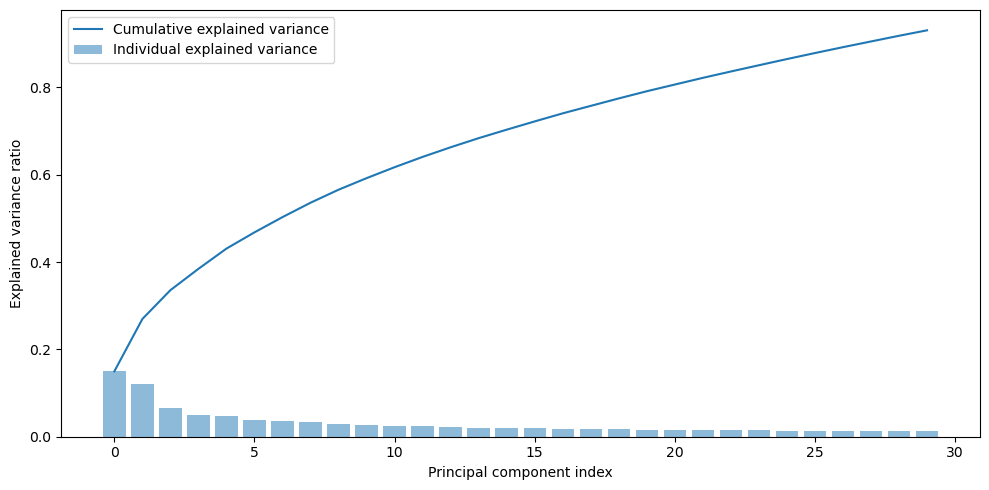

In [41]:
pca1 = PCA(n_components=N_COMPONENTS, random_state=SEED)
X_train_pca = pca1.fit_transform(X_train)
exp_var_pca = pca1.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
cum_sum_eigenvalues

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.plot(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

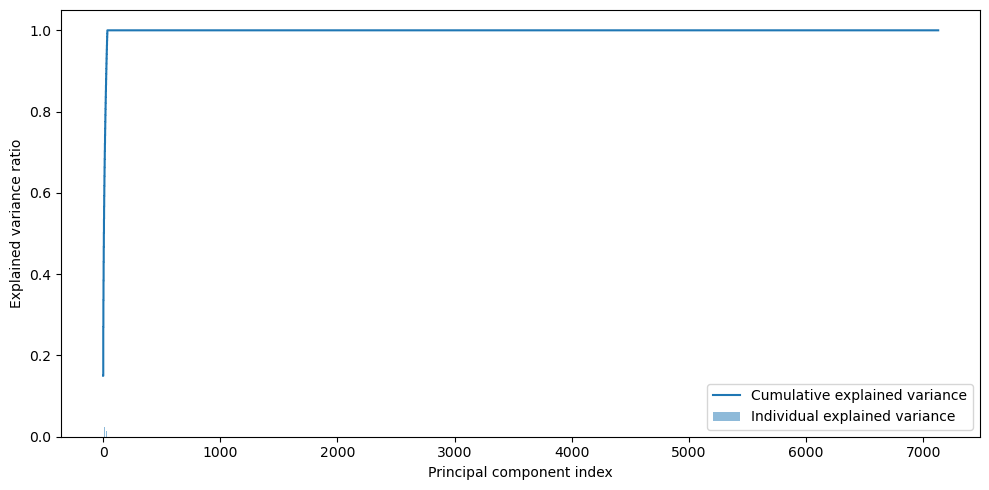

In [33]:
cov_matrix = np.cov(X_train, rowvar=False)
egnvalues, egnvectors = eigh(cov_matrix)
total_egnvalues = sum(egnvalues)
var_exp = [(i/total_egnvalues) for i in sorted(egnvalues, reverse=True)]

import matplotlib.pyplot as plt
cum_sum_exp = np.cumsum(var_exp)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

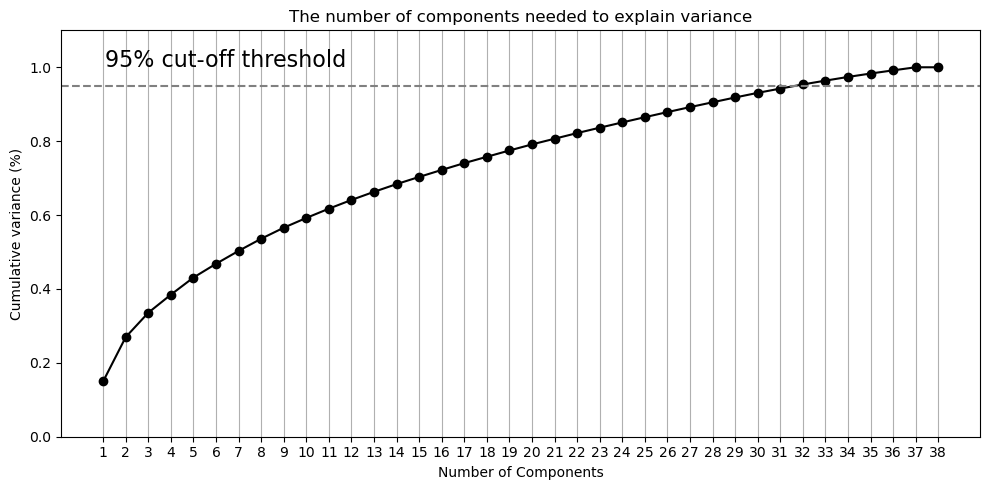

In [29]:
scaler = StandardScaler()
data_rescaled = X_train

pca = PCA().fit(data_rescaled)

plt.rcParams["figure.figsize"] = (10,5)

fig, ax = plt.subplots()
xi = np.arange(1, 39, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 39, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.savefig('pcavisualize_1.png', dpi=300)
plt.show()

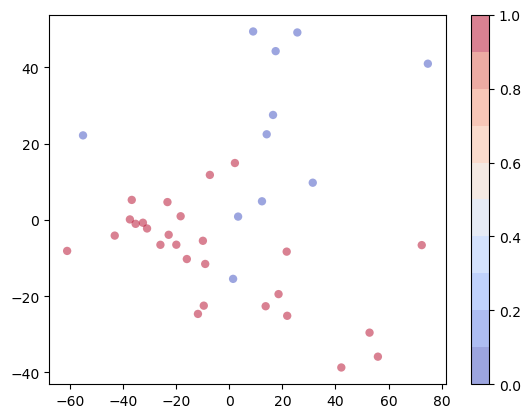

In [9]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 2],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 10))
plt.colorbar();

In [10]:
spca1 = SparsePCA(n_components=N_COMPONENTS, random_state=SEED, alpha=1, max_iter=10)
X_train_pca = spca1.fit_transform(X_train)
exp_var_pca = spca1.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
cum_sum_eigenvalues

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

AttributeError: 'SparsePCA' object has no attribute 'explained_variance_ratio_'

### PCA and SparsePCA

In [20]:
def create_pipe(clf, shrink_method, n=N_COMPONENTS):
    
    drop_constant = DropConstantFeatures(tol=0.98)
    scaler = StandardScaler()
    pca = PCA(n_components=n)
    spca = SparsePCA(n_components=n)
    add_features_names = AddFeatureNames(prefix="cmpnt_")

    if shrink_method == 'PCA':
        combined_features = FeatureUnion([("drop_constant", drop_constant), 
                                          ("scaler", scaler), 
                                          ("pca", pca),
                                          ("add_features_names", add_features_names)])
        
    elif shrink_method == 'SPCA':
        combined_features = FeatureUnion([("drop_constant", drop_constant), 
                                          ("scaler", scaler), 
                                          ("spca", spca),
                                          ("add_features_names", add_features_names)])
        
    elif shrink_method == 'None':
        combined_features = FeatureUnion([("drop_constant", drop_constant), 
                                          ("scaler", scaler), 
                                          ("add_features_names", add_features_names)])
        
    else:
        raise Exception("Input valid shrinking method from: {PCA, SPCA, None}")

        
    pipeline = Pipeline([("features", combined_features), 
                         ("clf", clf)])

    return pipeline

In [21]:
models = {'KNeighbors' : KNeighborsClassifier(),
          'RandomForest' : RandomForestClassifier(random_state=SEED),
          'LogisticReg' : LogisticRegression(random_state=SEED),
          'LGBMClassifier': LGBMClassifier(random_state=SEED)
          }
folds=5

def run_models(shrink: str, cv=folds):
    for name, model, in models.items():
        start = time.time()
        clf = model
        pipeline = create_pipe(clf, shrink_method=shrink, n=2)
        scores = cross_val_score(pipeline, 
                                 X_total,
                                 y_total,
                                 scoring='accuracy', 
                                 cv=cv, n_jobs=5, 
                                 error_score='raise')
        print(name, ': Mean Accuracy: %.3f and Standard Deviation: (%.3f) and Runtime: %.3f s' % (np.mean(scores), np.std(scores), time.time() - start))

print(f'N_COMPONENTS = {N_COMPONENTS}, SEED = {SEED}, CV = {folds}')
print(68 * '-')
print('None')
print(68 * '-')
run_models(shrink='None')
print(68 * '-')
print('PCA')
print(68 * '-')
run_models(shrink='PCA')
print(68 * '-')
print('SPCA')
print(68 * '-')
run_models(shrink='SPCA')
print(68 * '-')

N_COMPONENTS = 10, SEED = 2023, CV = 5
--------------------------------------------------------------------
None
--------------------------------------------------------------------
KNeighbors : Mean Accuracy: 0.790 and Standard Deviation: (0.103) and Runtime: 15.846 s
RandomForest : Mean Accuracy: 0.971 and Standard Deviation: (0.035) and Runtime: 6.174 s
LogisticReg : Mean Accuracy: 0.943 and Standard Deviation: (0.083) and Runtime: 3.659 s
LGBMClassifier : Mean Accuracy: 0.945 and Standard Deviation: (0.053) and Runtime: 7.525 s
--------------------------------------------------------------------
PCA
--------------------------------------------------------------------
KNeighbors : Mean Accuracy: 0.790 and Standard Deviation: (0.103) and Runtime: 3.116 s
RandomForest : Mean Accuracy: 0.929 and Standard Deviation: (0.111) and Runtime: 3.321 s
LogisticReg : Mean Accuracy: 0.943 and Standard Deviation: (0.083) and Runtime: 4.161 s
LGBMClassifier : Mean Accuracy: 0.945 and Standard Devia

In [22]:
def get_params(parameters, X, y, pipeline):

    grid = GridSearchCV(pipeline, 
                        parameters, 
                        scoring='accuracy', 
                        n_jobs=1, 
                        cv=3, 
                        error_score='raise')
    grid.fit(X, y)

    return grid

In [ ]:
clf = LogisticRegression(random_state=SEED)
pipeline = create_pipe(clf, shrink_method='PCA')

param_grid = dict(features__pca__n_components = list(range(1,10)),
                 clf__C = [0.1, 1.0, 10, 100],
                 clf__solver = ['liblinear', 'saga'],
                 clf__penalty = ['l2', 'l1'])

grid = get_params(param_grid, X_train, y_train, pipeline)

print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))